# Parameter Estimation Methods on Double Pendulum  Control Tasks

## Import packages

In [104]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy as sqrt
from autograd.numpy.linalg import norm
from autograd.numpy.linalg import inv
from autograd import jacobian
from autograd.test_util import check_grads
from collections import deque
np.set_printoptions(precision=4, suppress=True)
# Note: autograd does not work with np.block

## Double Pendulum Dynamics

In [168]:
#https://dassencio.org/33 equations of motion
from matplotlib.animation import FuncAnimation
def double_pendulum_dynamics(state, m1, m2, l1, l2, g, u):
    """
    Compute the derivatives for the double pendulum using the provided formulation.
    
    Args:
        state: [theta1, omega1, theta2, omega2] - state variables
        m1: Mass of the first pendulum
        m2: Mass of the second pendulum
        l1: Length of the first pendulum
        l2: Length of the second pendulum
        g: Acceleration due to gravity
        
    Returns:
        dstate_dt: Derivatives [dtheta1/dt, domega1/dt, dtheta2/dt, domega2/dt]
    """
    state = np.ravel(state)
    theta1, omega1, theta2, omega2 = state
    delta = theta2 - theta1

    # Compute alpha1, alpha2
    alpha1 = (l2 / l1) * (m2 / (m1 + m2)) * np.cos(delta)
    alpha2 = (l1 / l2) * np.cos(delta)

    # Compute f1 and f2
    f1 = (-l2 / l1) * (m2 / (m1 + m2)) * omega2**2 * np.sin(delta) - (g / l1) * np.sin(theta1)
    # print("f2", (l1 / l2) * omega1**2 * np.sin(delta) - (g / l2) * np.sin(theta2), "u", u/l2)
    f2 = (l1 / l2) * omega1**2 * np.sin(delta) - (g / l2) * np.sin(theta2)+(u[0]/l2)
  

    # Matrix A and its determinant
    detA = 1 - alpha1 * alpha2
    A_inv = (1 / detA) * np.array([[1, -alpha1], [-alpha2, 1]])

    # Solve for angular accelerations
    rhs = np.array([f1, f2])
    angular_accels = A_inv @ rhs

    omega1_dot, omega2_dot = angular_accels

    # Return the derivatives
    return np.array([omega1, omega1_dot, omega2, omega2_dot])
freq = 50.0 
h = 1/freq #50 Hz

# Runge-Kutta 4th order integration
def double_pen_rk4(x, u, m1, m2, l1, l2, g):
    k1 = double_pendulum_dynamics(x, m1, m2, l1, l2, g, u)
    k2 = double_pendulum_dynamics(x + 0.5 * h * k1, m1, m2, l1, l2, g, u)
    k3 = double_pendulum_dynamics(x + 0.5 * h * k2, m1, m2, l1, l2, g, u)
    k4 = double_pendulum_dynamics(x + h * k3, m1, m2, l1, l2, g, u)

    return x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# Parameters
m1, m2 = 1.0, 1.0  # masses
l1, l2 = 1.0, 1.0  # lengths
g = 9.81  # gravity
dt = 0.01  # time step



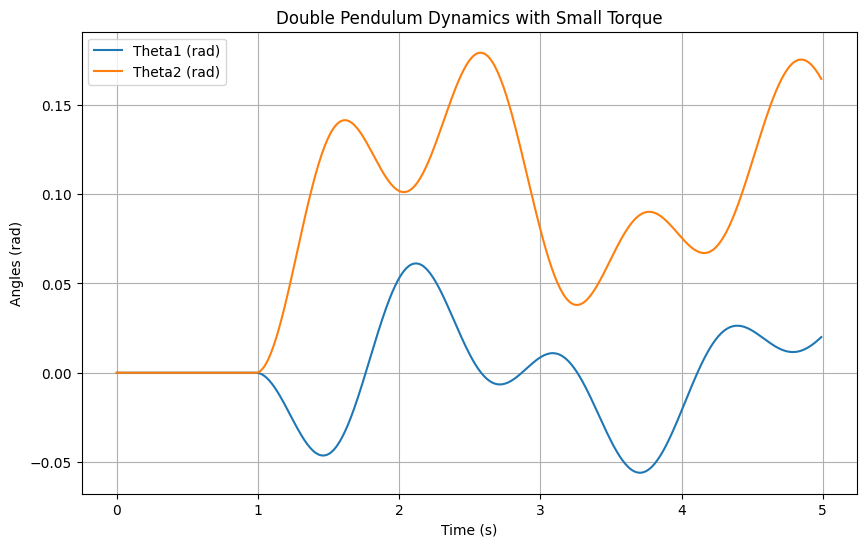

In [167]:
#teset dynamics:

# Simulation parameters
n_steps = 500  # Number of simulation steps
u = np.array([0.])  # Small constant torque
state = np.array([0.0, 0.0, 0.0, 0.0])  # Initial downward position
trajectory = []  # To store states over time

# Simulate the dynamics
for step in range(n_steps):
    if step == 100:
        u = np.array([1.0])
    # else:
    #     u = np.array([0.0])
    state = double_pen_rk4(state, u, m1, m2, l1, l2, g)
    trajectory.append(state)

trajectory = np.array(trajectory)

# Plot the angular positions over time
time = np.arange(n_steps) * dt
plt.figure(figsize=(10, 6))
plt.plot(time, trajectory[:, 0], label="Theta1 (rad)")
plt.plot(time, trajectory[:, 2], label="Theta2 (rad)")
plt.xlabel("Time (s)")
plt.ylabel("Angles (rad)")
plt.title("Double Pendulum Dynamics with Small Torque")
plt.legend()
plt.grid()
plt.show()

## LQR Controller 

In [ ]:
from scipy.linalg import solve_continuous_are
A_jac = jacobian(double_pen_rk4, 0)  # jacobian wrt x
B_jac = jacobian(double_pen_rk4, 1)  # jacobian wrt u
xg=np.array([0.0, 0.0, 0.0, 0.0])
u=np.array([0.0])
Anp = A_jac(xg, u, m1, m2, l1, l2, g)  # jacobian of the dynamics wrt x
Bnp = B_jac(xg, u, m1, m2, l1, l2, g).reshape(4,1)  # jacobian of the dynamics wrt u

def lqr(A, B, Q, R, n_steps=500):
    """
    Solves the continuous-time algebraic Riccati equation to compute the optimal gain matrix K.
    """
    P = Q
    for i in range(n_steps):
        K = inv(R + B.T @ P @ B) @ B.T @ P @ A
        P = Q + A.T @ P @ (A - B @ K)
    return K



# # Linearize the system
# A, B = linearize_double_pendulum(m1, m2, l1, l2, g)

# Define Q and R matrices based on desired penalties
max_dev_x = np.array([np.pi / 2, 1.0, np.pi / 2, 1.0])  # max deviations for states
max_dev_u = np.array([10.0])  # max control effort
Q = np.diag(1.0 / max_dev_x**2)
R = np.diag(1.0 / max_dev_u**2)

# Compute LQR gain matrix
K = lqr(Anp, Bnp, Q, R)
print(K)
# Control the double pendulum to stabilize it at the downward position
def lqr_controller(x_curr, x_desired, u_nom):
    """
    Compute control input using the LQR gain matrix.
    Returns:
        control_input: Control input to stabilize the system.
    """
    delta_x = x_curr - x_desired
    print("control",u_nom - K @ delta_x )
    return u_nom - K @ delta_x


# Simulation

control [-11.7367]
step:  0 
 controls:  [-11.7367] 
 position:  [ 0.1  0.  -0.1  0. ]
(1,)
control [-9.7875]
step:  1 
 controls:  [-9.7875] 
 position:  [0.10082480400171041, 0.08237876004908473, -0.1018834272579925, -0.18817602360779168]
(1,)
control [-8.2226]
step:  2 
 controls:  [-8.2226] 
 position:  [0.10228421129602261, 0.14575977295060605, -0.10526507119699688, -0.33786934626331167]
(1,)
control [-6.9709]
step:  3 
 controls:  [-6.9709] 
 position:  [0.10422313651928021, 0.19365108957987393, -0.10983166413656044, -0.45626691445165085]
(1,)
control [-5.9743]
step:  4 
 controls:  [-5.9743] 
 position:  [0.10651524231864795, 0.2289242681850375, -0.11532877753982813, -0.5492466440957959]
(1,)
control [-5.1852]
step:  5 
 controls:  [-5.1852] 
 position:  [0.10905768958577478, 0.2539261096766397, -0.12155003859120354, -0.6216089642095836]
(1,)
control [-4.565]
step:  6 
 controls:  [-4.565] 
 position:  [0.11176681939271138, 0.2705720673867179, -0.1283282763563417, -0.67726986396

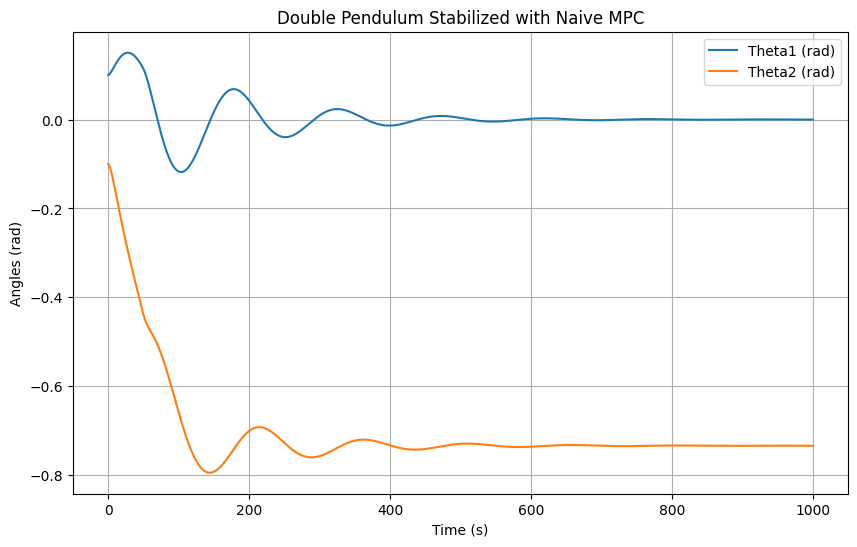

In [182]:
#simulate with naive MPC
def simulate_with_controller_naive_MPC(x0, x_nom,controller, u_nom=np.array([0.0]),  NSIM = 1000):
    x_all = []
    u_all = []
    x_curr = np.copy(x0)
    x_all.append(x_curr)
    max_u_curr = 10


    change_params = False

    # simulate the dynamics with the LQR controller
    for i in range(NSIM):
        # change mass
        if i == 50:
            change_params = True
            # mass_new = 2*mass
            g_new = 2*g
            u_nom_new = np.array([0.0])

        # MPC controller
        if i >= 60:
            u_curr = controller(x_curr, x_nom, u_nom_new)
        else:
            u_curr = controller(x_curr, x_nom, u_nom)
        if u_curr > max_u_curr:
            u_curr = max_u_curr
        print("step: ", i, "\n", "controls: ", u_curr, "\n", "position: ", x_curr)
        print(u_curr.shape)
        # postponing the dynamics model by telling it the correct parameters after several steps
        if change_params:
            x_curr = double_pen_rk4(x_curr, u_curr, m1, m2, l1, l2, g_new)
        else:
            x_curr = double_pen_rk4(x_curr, u_curr, m1, m2, l1, l2, g)

        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

        x_all.append(x_curr)
        u_all.append(u_curr)
    
    return x_all, u_all

desired_state = np.array([np.pi / 4, 0, np.pi / 4, 0])
initial_state = np.array([0.1,0,-0.1,0])  # Target state (downward position)

# Simulate the system using the naive MPC controller
x_all, u_all = simulate_with_controller_naive_MPC(initial_state, desired_state,  lqr_controller)
x_all = np.array(x_all)
# Visualizations
nsteps = len(x_all)
steps = np.arange(nsteps)
plt.figure(figsize=(10, 6))
plt.plot(steps, x_all[:, 0], label="Theta1 (rad)")
plt.plot(steps, x_all[:, 2], label="Theta2 (rad)")
plt.xlabel("Time (s)")
plt.ylabel("Angles (rad)")
plt.title("Double Pendulum Stabilized with Naive MPC")
plt.legend()
plt.grid()
plt.show()

Auxilary methods

In [220]:
def df_dg(x, u, m1, m2, l1, l2, g, h=1e-5):
    f_g = double_pen_rk4(x, u, m1, m2, l1, l2, g)

    f_g_plus_h = double_pen_rk4(x, u, m1, m2, l1, l2, g+h)

    df_dg = (f_g_plus_h - f_g) / h

    return df_dg
#can implement other gradients, implementing df_dm1g as an example
def df_dmg(x, u, m1, m2, l1, l2, g, h=1e-7):
    dfdm = np.zeros((x.shape[0], 2))
    dfdg = np.zeros((x.shape[0], 2))

    # Perturb mass (m)
    for i in range(x.shape[0]):
        x_plus_m = double_pen_rk4(x, u, m1 + h, m2, l1, l2, g)
        x_minus_m = double_pen_rk4(x, u, m1 - h, m2, l1, l2, g)
        dfdm[:, 0] = (x_plus_m - x_minus_m).flatten() / (2 * h)

    # Perturb gravity (g)
    for i in range(x.shape[0]):
        x_plus_g = double_pen_rk4(x, u, m1, m2, l1, l2, g + h)
        x_minus_g = double_pen_rk4(x, u, m1, m2, l1, l2, g - h)
        dfdg[:, 1] = (x_plus_g - x_minus_g).flatten() / (2 * h)
    
    # Combine into a single matrix
    dfdtheta = np.zeros((x.shape[0], 2))
    dfdtheta[:, 0] = dfdm[:,0]  # df/dm in the first column
    dfdtheta[:, 1] = dfdg[:,1]  # df/dg in the second column

    return dfdtheta

# function to visualize the trajectory
def visualize_trajectory_with_theta(x_all, u_all, theta_hat_all, theta_all, title):
    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(3, 1)

    # Plot the trajectory
    x_all = np.array(x_all)
    nsteps = len(x_all)
    steps = np.arange(nsteps)
    ax[0].plot(steps, x_all[:, 0], label="Theta1 (rad)", linewidth=2)
   # ax[0].plot(steps, x_all[:, 1], label="y", linewidth=2)
    ax[0].plot(steps, x_all[:, 2], label="Theta2 (rad)", linewidth=2)
    ax[0].legend()
    ax[0].title.set_text("Position")


    theta_all = np.array(theta_all)
    theta_hat_all = np.array(theta_hat_all)
    nsteps = len(theta_all)
    steps = np.arange(nsteps)
    ax[1].plot(steps, [array[:,0] for array in theta_all], label="theta", linewidth=2)
    ax[1].plot(steps, [array[:,0] for array in theta_hat_all], label="theta_hat", linewidth=2)
    ax[1].legend()
    ax[1].title.set_text("Param Estimates")

    u_all = np.array(u_all)
    nsteps = len(u_all)
    steps = np.arange(nsteps)
    ax[2].plot(steps, u_all[:, 0], label="u1", linewidth=2)
    # ax[2].legend()
    ax[2].title.set_text("Controls")

    plt.suptitle(title)
    plt.show()


## Parameter Estimation Methods

In [221]:
class NaiveRLS:
    def __init__(self, num_params, lambda_factor=0.97):
        self.num_params = num_params
        self.lambda_factor = lambda_factor
        self.theta = 0.                    # Parameter estimate
        self.P = 1000.                       # Large initial covariance matrix

    def update(self, x, y):
        # Reshape inputs to column vectors
        x = np.reshape(x, (13, 1))          # TODO: 13 is hard coded! Change this
        y = np.reshape(y, (13, 1))          # Compute Kalman gain
        P_x = self.P * x
        gain_denominator = self.lambda_factor + x.T @ P_x
        K = P_x / gain_denominator        # Update estimate
        y_pred = x * self.theta
        self.theta = self.theta + K.T @ (y - y_pred)        # Update covariance matrix
        self.P = (self.P - K.T @ x * self.P) / self.lambda_factor
        return self.theta

In [222]:
class EKF:
    def __init__(self, process_noise=1e-3, measurement_noise=1e-1):
        self.theta =0.                    # Initial gravity estimate
        self.P = 100.0                       # Initial covariance
        self.Q = process_noise                # Process noise covariance
        self.R = np.eye(13) * measurement_noise  # Measurement noise covariance

    def predict(self):
        # Prediction step
        self.P = self.P + self.Q

    def update(self, x, y):
        """
        x: 13x1 Jacobian vector (sensitivity of dynamics to gravity)
        y: 13x1 observation vector (state differences)
        """
        # Ensure x and y are column vectors
        x = np.reshape(x, (13, 1))
        y = np.reshape(y, (13, 1))
        print(x,y)
        # Innovation covariance
        S = (x @ (self.P * x.T)) + self.R
        # Kalman gain
        K = (self.P * x.T) @ np.linalg.inv(S)  # K is 1x13

        # Update state estimate
        self.theta = self.theta + (K @ y).item()
        print(self.theta)
        # Update covariance
        self.P = self.P - (K @ S @ K.T).item()
        return self.theta

In [223]:
class RK_v2:
    def __init__(self, alpha=0.3):
        self.alpha = alpha

    def iterate(self, A, b, x0, num_iterations, tol = 0.01):
        """
        A: (num_states, num_param)
        x: (num_param, 1)
        b: (num_states, 1)
        """
        self.A = A
        self.b = b
        self.m = A.shape[0]  # m is the number of rows, n is the number of columns
        self.n = A.shape[1]
        self.x = np.array([x0]).reshape(self.n,1)  # Initial estimate of solution
       # print(A.shape, b.shape, self.x.shape)
        # print("cond: ",np.linalg.cond(A))
        # print("A: ", self.A)
        # print("b: ", self.b)
        # print("x0: ", self.x)
        # col_norms = np.linalg.norm(A, axis=0, keepdims=True)

        # Normalize each column
        # A = A / col_norms
        # print("A= ", A)

        for _ in range(num_iterations):
            # Compute exponential weighting for the rows
            row_norms = np.linalg.norm(A,axis=1)**2
            # probabilities = row_norms / np.sum(row_norms)
            mask = (row_norms > 1e-6)
            # print(mask)
            exponential_weights =  mask * np.exp(self.alpha * row_norms)
            probabilities = exponential_weights / (np.sum(exponential_weights))
            i = np.random.choice(self.m, p = probabilities)            # Update rule using the selected row
            # print(i)
            #print(i)
            a_i = np.array(self.A[i]) #.reshape(13,1)
            b_i = np.array(self.b[i])#.reshape(1,13)
            residual = b[i] - np.dot(A[i], self.x)
            if np.abs(residual) < tol:
                print("Converged")
                break
            # residual = np.dot(self.A, self.x) - b
            
            # if np.abs(residual).sum() < tol:
            #     print("tolerance hit")
            #     break
            increment = ((b_i - np.dot(a_i,self.x)) / (np.linalg.norm(a_i)**2))*a_i
            increment = increment.reshape(self.n,1)
            # print( increment)
            self.x = self.x + increment
        return self.x

In [224]:
def entropy_score(df_dg_window, b_window):
    """
    Compute entropy-based score for a given window of (df_dg, b).
    Lower entropy means a more informative motion sample.
    """
    # import pdb; pdb.set_trace()
    # Convert deque lists into proper numpy arrays
    df_dg_window = np.vstack(df_dg_window)  # Shape (num_samples, 13)
    b_window = np.vstack(b_window)  # Shape (num_samples, 13)

    # Ensure they are 2D before stacking
    if df_dg_window.ndim == 1:
        df_dg_window = df_dg_window.reshape(-1, 1)
    if b_window.ndim == 1:
        b_window = b_window.reshape(-1, 1)

    # Stack and ensure it's 2D
    stacked_data = np.hstack((df_dg_window, b_window))  # Shape (num_samples, 26)
    cov_matrix = np.cov(stacked_data, rowvar=False)  # Compute covariance matrix

    # Compute entropy as log determinant of covariance matrix
    entropy = 0.5 * np.linalg.slogdet(cov_matrix)[1]
    return entropy


def simulate_with_controller_entropy_RK(x0, x_nom,  controller, u_nom = np.array([0]), NSIM=600):
    x_all, u_all, theta_all, theta_hat_all = [], [], [], []
    x_curr = np.copy(x0)

    # Initialize parameters

    theta_gt = np.array([[1.0], [9.81]]) # [m1, gravity] (2,)
    theta_hat = theta_gt.copy()
    theta_hat_prev = theta_gt.copy()

    changing_step = 100
    change_params, clear_history = False, False
    u_curr = controller(x0, x_nom, u_nom)

    rk = RK_v2()

    # Priority queue for history (fixed size)
    queue_size = 5
    df_dg_queue, b_queue = deque(maxlen=queue_size), deque(maxlen=queue_size)

    # Keep track of scores for removal
    score_queue = deque(maxlen=queue_size)

    # Simulation loop
    for i in range(NSIM):

        # Change system parameters at specific step
        if i == changing_step:
            change_params = True
            theta_gt = np.array([[1.0*2], [9.81*2]])  


        # Compute control
        u_nom = np.array([0.0])
        u_prev, x_prev, theta_hat_prev = u_curr, x_curr, theta_hat
        u_curr = controller(x_curr, x_nom, u_nom)

        x_curr = double_pen_rk4(x_curr, u_curr, theta_gt[0][0], m2, l1, l2, theta_gt[1][0])
        theta_all.append(theta_gt)

           

        # Compute updates for g_hat x, u, m1, m2, l1, l2
        print(theta_hat_prev[0][0], theta_hat_prev[1][0])
        dfdtheta_at_theta_prev = df_dmg(x_prev, u_prev, theta_hat_prev[0][0], m2, l1, l2, theta_hat_prev[1][0]) # shape: (num_states, num_params)
        f_at_theta_prev = double_pen_rk4(x_prev, u_prev, theta_hat_prev[0][0], m2, l1, l2, theta_hat_prev[1][0]) 
        b = (x_curr.reshape(-1,1) - f_at_theta_prev.reshape(-1,1) + np.dot(dfdtheta_at_theta_prev, theta_hat_prev)) # shape: (num_states,1) 

        if i%50 == 0:
            b_all = b
            dfdtheta_at_theta_prev_all = dfdtheta_at_theta_prev
        else:
            b_all = np.vstack((b_all, b))

            dfdtheta_at_theta_prev_all = np.vstack((dfdtheta_at_theta_prev_all, dfdtheta_at_theta_prev.reshape(-1,2)))
            #print("A: ", dfdtheta_at_theta_prev_all)
            #print("b:", b_all)
            print("theta_hat: ", theta_hat_prev)
            theta_hat = rk.iterate(dfdtheta_at_theta_prev_all, b_all, theta_hat_prev, 1000, 0.001)
            lsq_soln, residuals, rank, s = np.linalg.lstsq(dfdtheta_at_theta_prev_all, b_all, rcond=None)
            print("km soln: ", theta_hat)
            print("lsq soln: ", lsq_soln)

        # Store results
        x_all.append(x_curr.tolist())
        u_all.append(u_curr.tolist())
        theta_hat_all.append(theta_hat)

    return x_all, u_all, theta_hat_all, theta_all

control [-11.7367]
control [-11.7367]
1.0 9.81
control [-9.7875]
1.0 9.81
Converged
km soln:  [[0.9998]
 [9.8159]]
lsq soln:  [[ 0.6853]
 [22.0003]]
control [-8.2226]
0.999809708204819 9.815853830866262
Converged
km soln:  [[1.4333]
 [9.8356]]
lsq soln:  [[ 0.651 ]
 [22.9034]]
control [-6.9709]
1.4332641100670256 9.835624923852333
Converged
km soln:  [[1.2097]
 [9.828 ]]
lsq soln:  [[ 0.9054]
 [16.6328]]
control [-5.9743]
1.2096601008353722 9.828029319473673
Converged
km soln:  [[1.2097]
 [9.828 ]]
lsq soln:  [[ 0.966 ]
 [15.1244]]
control [-5.1852]
1.2096601008353722 9.828029319473673
Converged
km soln:  [[1.2718]
 [9.836 ]]
lsq soln:  [[ 1.0144]
 [13.9884]]
control [-4.565]
1.271819668481655 9.835962932938388
Converged
km soln:  [[1.6513]
 [9.9388]]
lsq soln:  [[ 1.0526]
 [13.1444]]
control [-4.0821]
1.6513063477289742 9.938832517068624
Converged
km soln:  [[ 1.6102]
 [10.0904]]
lsq soln:  [[ 1.0846]
 [12.4892]]
control [-3.7106]
1.6102149219768271 10.090419099595078
Converged
km sol

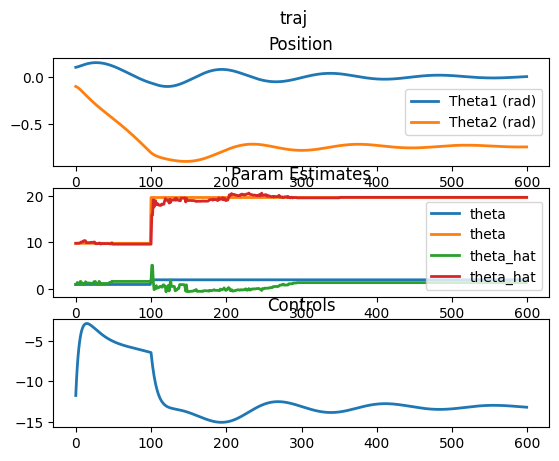

In [229]:
x_lqr, u_lqr, theta_hat, theta = simulate_with_controller_entropy_RK(initial_state, desired_state, lqr_controller)
visualize_trajectory_with_theta(x_lqr, u_lqr, theta_hat, theta, "traj")